# XGBOOST refresher 

* try baseline model
* add in holidays
* add features from fbprophet

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import xgboost as xgb
#plt.style.use('fivethirtyeight')

# reference
# https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet

In [2]:
data_source_dir = r'/home/jasonchandatascience/competition_prep/data/hourly_energy_consumption'

In [3]:
def GetPath(file, directory=data_source_dir):
    return os.path.join(directory, file)

In [4]:
# had to edit permission using !chmod 644 *.csv for all csv files
pjme = pd.read_csv(GetPath('PJME_hourly.csv'), index_col=[0], parse_dates=[0])

In [5]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [6]:
X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Baseline XGBOOST

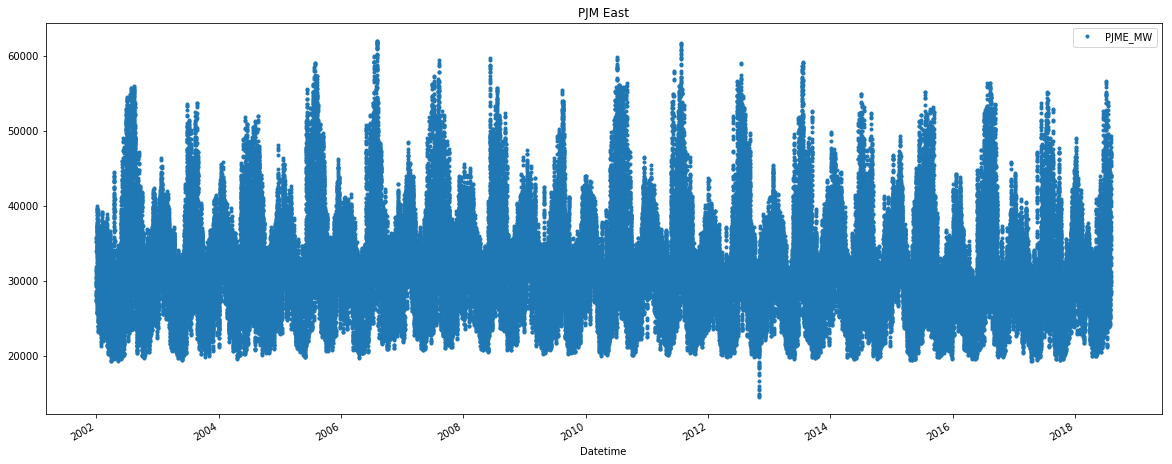

In [8]:
pjme.plot(style='.', figsize=(20,8), title='PJM East')

In [9]:
?xgb.XGBRegressor

Init signature: xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain', **kwargs)
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.

Parameters
----------
max_depth : int
    Maximum tree depth for base learners.
learning_rate : float
    Boosting learning rate (xgb's "eta")
n_estimators : int
    Number of boosted trees to fit.
silent : boolean
    Whether to print messages while running boosting.
objective : string or callable
    Specify the learning task and the corresponding learning objective or
    a custom objective function to be used (see note below).
booster: string
    Specify which booster to use: gbtree, gblinear or dart.
nthread 

In [10]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=50) 

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-rmse:29710.4	validation_1-rmse:28762.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:3259.46	validation_1-rmse:3809.04
[100]	validation_0-rmse:3034.02	validation_1-rmse:3743.08
[150]	validation_0-rmse:2920.09	validation_1-rmse:3714.78
[200]	validation_0-rmse:2837.17	validation_1-rmse:3754.38
Stopping. Best iteration:
[149]	validation_0-rmse:2923.14	validation_1-rmse:3712.2



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

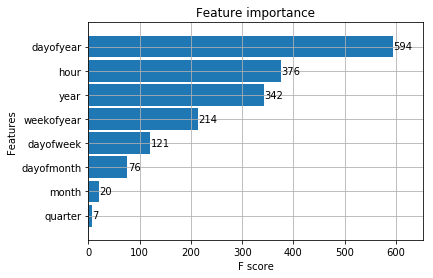

In [12]:
from xgboost import plot_importance, plot_tree
plot_importance(reg, height=0.9)

In [13]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

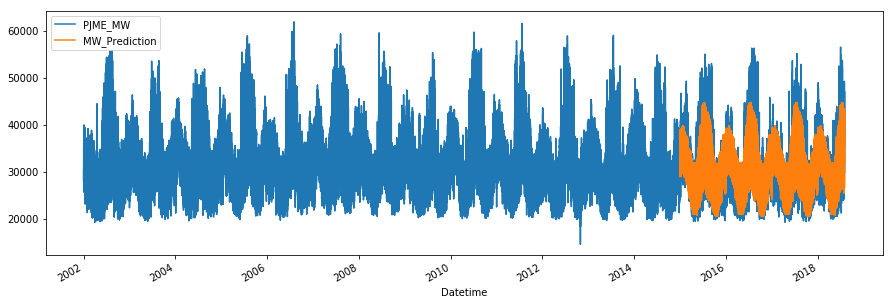

In [14]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [15]:
import matplotlib
import datetime

# First month of predictions

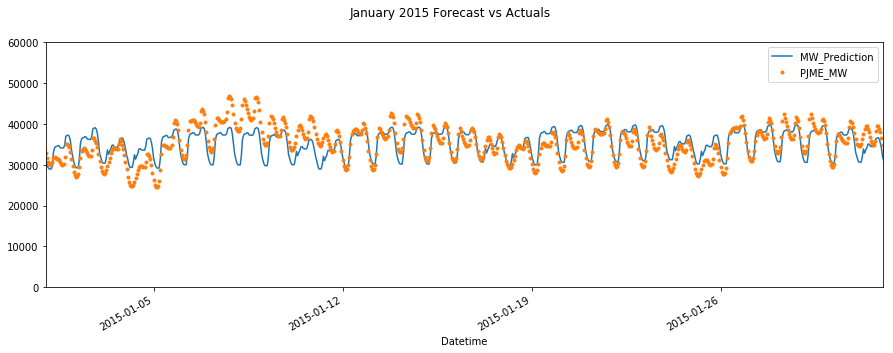

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower=datetime.date(2015, 1, 1), upper=datetime.date(2015, 2, 1))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

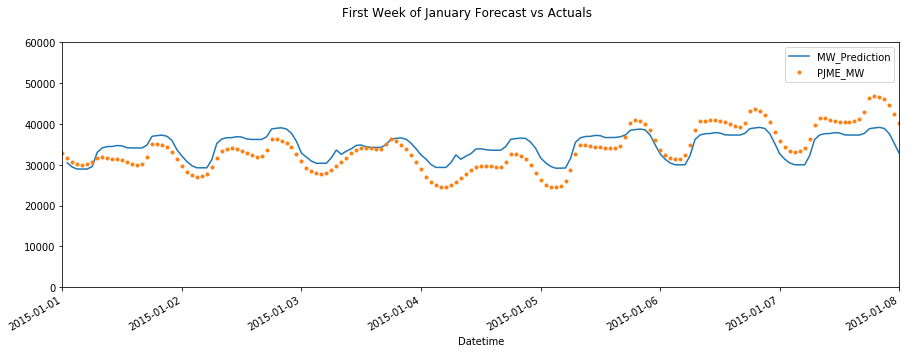

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower=datetime.date(2015, 1, 1), upper=datetime.date(2015, 1, 8))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Error Metrics on Test Set

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.94944673745318

# Best and Worst Days

In [23]:
pjme_test.head()

,PJME_MW,MW_Prediction
Datetime,,
2015-12-31 01:00:00,24305.0,28804.365234
2015-12-31 02:00:00,23156.0,27663.097656
2015-12-31 03:00:00,22514.0,27125.912109
2015-12-31 04:00:00,22330.0,27125.912109
2015-12-31 05:00:00,22773.0,27125.912109


In [24]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)

In [35]:
error_by_day = pjme_test.merge(create_features(pjme_test), on="Datetime").groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [36]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36986.964844 -8587.006429  8587.006429
2017 2     24          26445.083333   33814.503906 -7369.422445  7369.422445
2015 12    25          24466.083333   31584.923828 -7118.841390  7118.841390
2017 2     20          27070.583333   34100.781250 -7030.197754  7030.197754
2015 7     3           30024.875000   37021.031250 -6996.156169  6996.156169
2017 6     28          30531.208333   37526.589844 -6995.380371  6995.380371
     2     8           28523.833333   35511.699219 -6987.864258  6987.864258
     9     2           24201.458333   31180.390625 -6978.933105  6978.933105
     2     25          24344.458333   31284.279297 -6939.820150  6939.820150
2018 2     21          27572.500000   34477.417969 -6904.919352  6904.919352

Notice anything about the over forecasted days?

#1 worst day - July 4th, 2016 - is a holiday.
#3 worst day - December 25, 2015 - Christmas
#5 worst day - July 4th, 2016 - is a holiday.
Looks like our model may benefit from adding a holiday indicator.

In [37]:
error_by_day.sort_values('abs_error', ascending=False).head(10)


PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31753.224609  13432.608887  13432.608887
           14          44427.333333   31058.818359  13368.514404  13368.514404
     9     10          40996.166667   29786.179688  11209.987793  11209.987793
           9           43836.958333   32831.035156  11005.923828  11005.923828
2015 2     20          44694.041667   33814.503906  10879.535889  10879.535889
2018 1     6           43565.750000   33435.265625  10130.485921  10130.485921
2016 8     12          45724.708333   35609.312500  10115.394287  10115.394287
2017 5     19          38032.583333   28108.976562   9923.606689   9923.606689
     12    31          39016.000000   29314.683594   9701.315430   9701.315430
2015 2     21          40918.666667   31284.279297   9634.388184   9634.388184

In [38]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27775.351562  -69.768148  229.585205
2015 10    28          28500.958333   28160.875000  340.083740  388.023356
2016 10    8           25183.333333   25535.669922 -352.337402  401.017090
     5     1           24503.625000   24795.419922 -291.794515  428.289307
2017 10    29          24605.666667   24776.271484 -170.605225  474.628988
2016 9     16          29258.500000   29397.271484 -138.770833  491.070312
     3     20          27989.416667   27620.132812  369.284831  499.750488
     10    2           24659.083333   25134.919922 -475.836670  516.188232
2017 10    14          24949.583333   25399.728516 -450.145996  520.855794
2015 11    1           24253.962963   24415.839844 -161.876374  530.351490

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may



## Worst Day

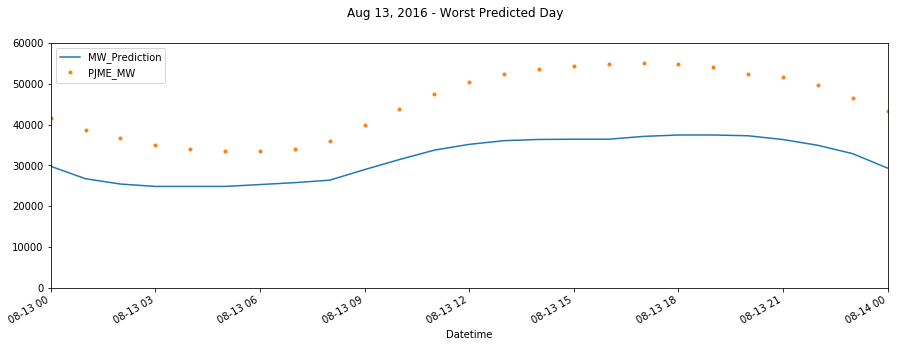

In [41]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower=datetime.date(2016, 8, 13), upper=datetime.date(2016, 8, 14))
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Best Day

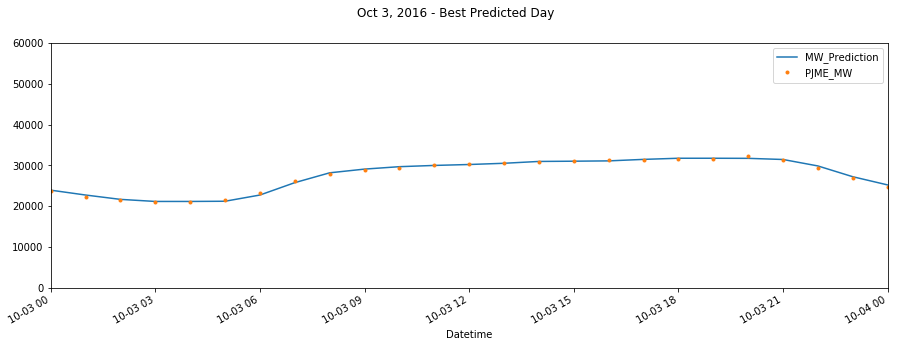

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower=datetime.date(2016, 10, 3), upper=datetime.date(2016, 10, 4))
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

# XGBOOST with holidays

In [44]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(), end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(), end=pjme_test.index.max())

In [56]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']]
holiday_df['holiday'] = 1
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,holiday
Datetime,
2003-01-01 00:00:00,1
2002-12-25 01:00:00,1
2002-12-25 02:00:00,1
2002-12-25 03:00:00,1
2002-12-25 04:00:00,1


In [63]:
X_train = X_train.merge(holiday_df, on="Datetime", how="left").fillna(0)

In [64]:
X_train['holiday'] = X_train['holiday'].astype(int)

In [66]:
X_test = X_test.merge(holiday_df, on="Datetime", how="left").fillna(0)

In [67]:
X_test['holiday'] = X_test['holiday'].astype(int)

# Modelling with holidays

In [69]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=50) 

[0]	validation_0-rmse:29710.4	validation_1-rmse:28762.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.


/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[50]	validation_0-rmse:3251.53	validation_1-rmse:3788.83
[100]	validation_0-rmse:3007.79	validation_1-rmse:3722.07
[150]	validation_0-rmse:2910.7	validation_1-rmse:3709.04
[200]	validation_0-rmse:2818.32	validation_1-rmse:3764.29
[250]	validation_0-rmse:2759.6	validation_1-rmse:3769.82
Stopping. Best iteration:
[151]	validation_0-rmse:2906.89	validation_1-rmse:3704.58



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

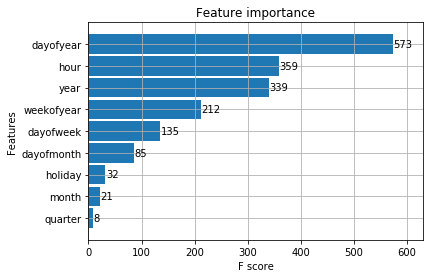

In [70]:
plot_importance(reg, height=0.9)

In [71]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

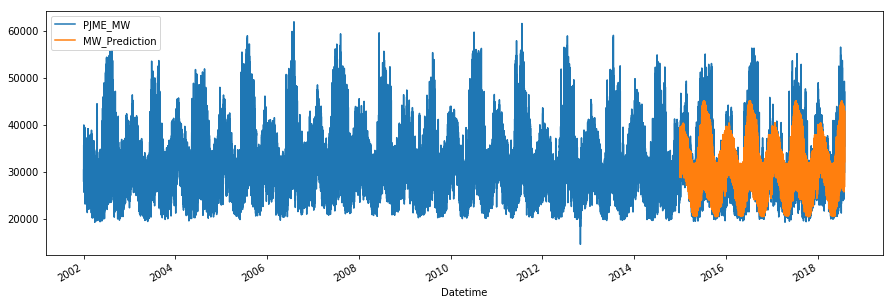

In [72]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [73]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.923546203345527

slightly reduced MAPE from adding the holidays

# Using features from fbprophet

In [74]:
from fbprophet import Prophet

In [143]:
# Setup and train model
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

In [144]:
pjme_test.tail()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,...,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW,MW_Prediction
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-31 20:00:00,30070.762714,-5737.745830,94492.153935,-15945.450034,81899.142459,0.0,0.0,0.0,0.0,0.0,...,20,1,3,7,2018,212,31,31,40289.0,38380.871094
2018-07-31 21:00:00,30070.724906,-7626.148430,92951.092672,-15948.111980,81902.271576,0.0,0.0,0.0,0.0,0.0,...,21,1,3,7,2018,212,31,31,39938.0,38285.535156
2018-07-31 22:00:00,30070.687097,-9229.451462,91958.219948,-15950.773926,81905.400693,0.0,0.0,0.0,0.0,0.0,...,22,1,3,7,2018,212,31,31,38610.0,38049.757812
2018-07-31 23:00:00,30070.649288,-9919.908633,89825.773021,-15953.435872,81908.529810,0.0,0.0,0.0,0.0,0.0,...,23,1,3,7,2018,212,31,31,35950.0,34442.667969
2018-08-01 00:00:00,30070.611479,-12304.000489,85890.860814,-15956.097818,81911.658927,0.0,0.0,0.0,0.0,0.0,...,0,2,3,8,2018,213,1,31,33072.0,31456.302734


In [145]:
future = model.make_future_dataframe(pjme_test.shape[0]-23, freq='H')

In [146]:
# note that doing it this way will exclude the training set date time
pjme_full = model.predict(future)

In [147]:
pjme_full.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King, Jr. Day',
       'Martin Luther King, Jr. Day_lower',
       'Martin Luther King, Jr. Day_upper', 'Memorial Day',
       'Memorial Day_lower', 'Memorial Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       

In [148]:
pjme_full_set = pjme_full.rename(columns={'ds':'Datetime'})

In [149]:
pjme_full_set.drop(['yhat_lower', 'yhat_upper','yhat'], axis=1, inplace=True)

In [150]:
whole_set = pjme_full_set.set_index('Datetime').merge(features_and_target, on="Datetime", how="inner")

In [151]:
whole_set.columns

Index(['trend', 'trend_lower', 'trend_upper', 'Christmas Day',
       'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King, Jr. Day',
       'Martin Luther King, Jr. Day_lower',
       'Martin Luther King, Jr. Day_upper', 'Memorial Day',
       'Memorial Day_lower', 'Memorial Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiving_upper', 'Veterans Da

In [152]:
split_date = '01-Jan-2015'
pjme_train = whole_set.loc[whole_set.index <= split_date].copy()
pjme_test = whole_set.loc[whole_set.index > split_date].copy()

In [153]:
y_train = pjme_train['PJME_MW']
X_train = pjme_train.drop(['PJME_MW'], axis=1)

y_test = pjme_test['PJME_MW']
X_test = pjme_test.drop(['PJME_MW'], axis=1)

In [154]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=50) 

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	validation_0-rmse:29675.2	validation_1-rmse:28713.9
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:3098.72	validation_1-rmse:3877.48
[100]	validation_0-rmse:2960.93	validation_1-rmse:3866.24
[150]	validation_0-rmse:2845.5	validation_1-rmse:3830.67
[200]	validation_0-rmse:2759.14	validation_1-rmse:3818.67
[250]	validation_0-rmse:2680.65	validation_1-rmse:3811.7
[300]	validation_0-rmse:2613.39	validation_1-rmse:3789.39
[350]	validation_0-rmse:2547.16	validation_1-rmse:3818.84
Stopping. Best iteration:
[299]	validation_0-rmse:2613.66	validation_1-rmse:3788.6



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

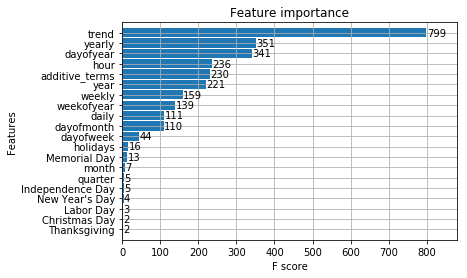

In [155]:
plot_importance(reg, height=0.9)

In [156]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

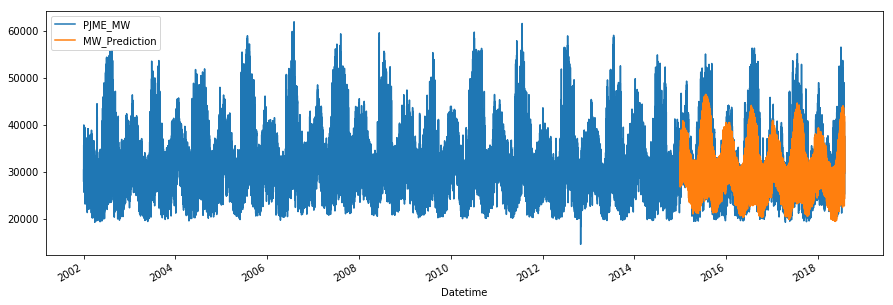

In [157]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [158]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.61032470563658